モジュールのインポート

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import joblib
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor
import optuna.integration.lightgbm as lgb
# import lightgbm as lgb
from lightgbm import LGBMRegressor

データのロード

In [2]:
water_data = pd.read_csv('./train/waterlevel/data.csv')
water_stations = pd.read_csv('./train/waterlevel/stations.csv')
rainfall_data = pd.read_csv('./train/rainfall/data.csv')
rainfall_stations = pd.read_csv('./train/rainfall/data.csv')
# 時系列モデルでない場合，潮位データは使いづらい
# tide_data = pd.read_csv('./train/rainfall/data.csv')
# tide_stations = pd.read_csv('./train/rainfall/data.csv')

In [3]:
# 学習に使用する期間を限定
# 1500日目以前には日付の欠損があったり，水位の基準値が変わる地点があるため，
# 学習期間に入れるときは注意が必要
start_date = 1500
end_date = 2190
water_data_new = water_data.query('date >= @start_date and date <= @end_date')
rainfall_data_new = rainfall_data.query('date >= @start_date and date <= @end_date')
# tide_data_new = tide_data.query('date >= @start_date and date <= @end_date')

水位の前処理

In [4]:
# 評価対象の station をリスト化する
water_stations_eval = water_stations.query('評価対象 == 1').reset_index(drop=True)
water_stations_eval_list = np.array(water_stations_eval['観測所名称'])

# 評価対象になっている station のみを学習対象とする
water_data_new = water_data_new[water_data_new['station'].isin(water_stations_eval_list)]

# 水位の station をエンコーディングするための辞書をつくる
WATER_STATION_DICT = dict()
for i, v, in enumerate(water_stations_eval_list):
    WATER_STATION_DICT[v] = i
WATER_STATION_DICT_REVERSE = {v: k for k, v in WATER_STATION_DICT.items()}

In [5]:
# 河川名のラベルエンコーディング
# 河川名とそれに対応するインデックス (整数) の辞書を作る
river_name_list = water_stations_eval['河川名'].unique()
river_name_dict = dict()
for i, item in enumerate(river_name_list):
    river_name_dict[item] = i

# 観測所と河川のインデックスを対応づけた辞書を作る
RIVER_DICT = dict()
for row in water_stations_eval.itertuples():
    RIVER_DICT[row.観測所名称] = river_name_dict[row.河川名]

# 水系名のラベルエンコーディング
# 水系名とそれに対応するインデックス (整数) の辞書を作る
system_name_list = water_stations_eval['水系名'].unique()
system_name_dict = dict()
for i, item in enumerate(system_name_list):
    system_name_dict[item] = i

# 観測所と水系のインデックスを対応づけた辞書を作る
SYSTEM_DICT = dict()
for row in water_stations_eval.itertuples():
    SYSTEM_DICT[row.観測所名称] = system_name_dict[row.水系名]

# 観測所ごとの緯度，経度
LOC_DICT = dict()
for row in water_stations_eval.itertuples():
    LOC_DICT[row.観測所名称] = (row.緯度, row.経度)

# 辞書の保存
# 毎回保存する必要はない
# with open('./RF_submission/src/water_station_dict.json', mode='w') as f:
#     json.dump(WATER_STATION_DICT, f)
# with open('./RF_submission/src/river_dict.json', mode='w') as f:
#     json.dump(RIVER_DICT, f)
# with open('./RF_submission/src/system_dict.json', mode='w') as f:
#     json.dump(SYSTEM_DICT, f)
# with open('./RF_submission/src/loc_dict.json', mode='w') as f:
#     json.dump(LOC_DICT, f)

In [6]:
# 欠損している日付を埋める
# 欠損している日付はメモしていおいて後で学習から外すことも可能
# groups = water_data_new.groupby('station')
# data = []
# set1 = set(range(start_date, end_date+1))
# for name, group in groups:
#     sample = group.iloc[0, :]
#     set2 = set( group['date'].unique())
#     subset  = set1.difference(set2)
#     for date in subset:
#         tmp = [float('nan') for i in range(27)]
#         tmp[0] = date
#         tmp[1] = sample.station
#         tmp[2] = sample.river
#         data.append(tmp)
# df_lack = pd.DataFrame(data, columns=water_data_new.columns.values)
# water_data_new = pd.concat([water_data_new, df_lack])

In [7]:
# 時間と値を縦に並べた新しい DataFrame をつくる
data = []
for row in water_data_new.itertuples(index=False):
    for i in range(24):
        v = row[3+i]
        tmp = (row.date, row.station, row.river, i, v)
        data.append(tmp)
water_data_reshaped = pd.DataFrame(data, columns=['date', 'station', 'river', 'hour', 'value'])

In [8]:
# 特徴量の追加
# 観測所名，河川名，水系名，緯度，経度
groups = water_data_reshaped.groupby('station')
df_new = pd.DataFrame()
for name, group in groups:
    df_tmp = group.copy()
    df_tmp['station_id'] = WATER_STATION_DICT[name]
    df_tmp['river_id'] = RIVER_DICT[name]
    df_tmp['system_id']  = SYSTEM_DICT[name]
    df_tmp['latitude'] = LOC_DICT[name][0]
    df_tmp['longitude'] = LOC_DICT[name][1]
    df_new = pd.concat([df_new, df_tmp])
water_data_reshaped = df_new

In [9]:
# 水位の欠損値をすべて float 型に変換
water_data_reshaped['value'] = pd.to_numeric(water_data_reshaped['value'], errors='coerce')

# 欠損値を時系列順 に埋める
# station, date, hour の順にソート
water_data_reshaped.sort_values(['station_id', 'date', 'hour'], inplace=True)
groups = water_data_reshaped.groupby('station_id')
df_new = pd.DataFrame()
for _, group in groups:
    df_tmp = group.copy()
    # 時間に対して後ろ向きに埋めた後、前向きに埋める
    df_tmp['value'].fillna(method='bfill', inplace=True)
    df_tmp['value'].fillna(method='ffill', inplace=True)
    df_new = pd.concat([df_new, df_tmp])
water_data_reshaped = df_new

In [10]:
# 水位の変化のパターンをグラフで見る
# id = WATER_STATION_DICT['大須']
# tmp = water_data_reshaped[water_data_reshaped['date'] > end_date - 100].sort_values(['station_id', 'date', 'hour']).reset_index()
# tmp2 = tmp[tmp['station_id'] == id]
# tmp2['value'].plot()

In [11]:
# 河口で潮位の影響を受ける観測所をリストアップ
periodic_list = [6, 37, 113, 114, 129, 130, 131]

雨量の前処理

In [12]:
# 時間と値を縦に並べた新しい DataFrame をつくる
data = []
for row in rainfall_data_new.itertuples(index=False):
    for i in range(24):
        v = row[3+i]
        tmp = (row.date, row.station, row.city, i, v)
        data.append(tmp)
rainfall_data_reshaped = pd.DataFrame(data, columns=['date', 'station', 'city', 'hour', 'value'])

In [13]:
# 水位の欠損値をすべて float 型に変換
rainfall_data_reshaped['value'] = pd.to_numeric(rainfall_data_reshaped['value'], errors='coerce')

In [14]:
# その日広島県で降った雨の合計
rainfall_sum = rainfall_data_reshaped.groupby('date').sum()['value'].reset_index()

データセットの作成

In [15]:
# 水位データを基にデータセットを作る
dataset = water_data_reshaped.copy()

In [16]:
# 前日の23時の水位と前日を特徴量として追加
# 日付が欠損していないのを前提としている
# データセットをソートしておく
dataset.sort_values(['station_id', 'date', 'hour'], inplace=True)
# 23時，0時のデータのみ取り出す
df_tmp1 = dataset[dataset['hour']  == 23]
df_tmp2 = dataset[dataset['hour'] == 0]
# それぞれの station，date について前日23時，0時のデータを24時間分リピート
df_last23 =  np.repeat(df_tmp1['value'].values, 24, axis=0)
df_last0 =  np.repeat(df_tmp2['value'].values, 24, axis=0)
# 差分を取る
diff = df_last0 - df_last23
# 1日分ずらして挿入
dataset['value_last23'] = float('nan')
dataset.iloc[24:, -1] = df_last23[:-24]
dataset['value_diff'] = float('nan')
dataset.iloc[24:, -1] = diff[:-24]
# 初日は他の station のデータが入っているのでクリア
row_indexer = dataset[dataset['date'] == start_date].index
dataset.loc[row_indexer, 'value_last23'] = float('nan')
dataset.loc[row_indexer, 'value_diff'] = float('nan')

In [17]:
# 前日県内で降った雨の総量を追加
# 日付が欠損していないのを前提としている
groups = dataset.groupby(['date'])
df_new = pd.DataFrame()
for date, group in groups:
    if date > start_date:
        sum = rainfall_sum[rainfall_sum['date'] == date - 1]['value'].iat[-1]
    else:
        sum = float('nan')
    group['rainfall_sum'] = sum
    df_new = pd.concat([df_new, group])
dataset = df_new

In [18]:
# 最後にソートしておく
dataset.sort_values(['station_id', 'date', 'hour'], inplace=True)
# 最後の10日間はテストに使う
dataset_train = dataset[dataset['date'] < end_date - 10].copy()

In [19]:
# 水位が周期的なデータとそうでないデータに分ける
dataset_periodic = dataset_train[dataset_train['station_id'].isin(periodic_list)]
dataset_non_periodic = dataset_train[~dataset_train['station_id'].isin(periodic_list)]

予測

In [20]:
# 特徴量を選定
features = ['station_id', 'river_id', 'system_id', 'latitude', 'longitude', 'hour', 'rainfall_sum', 'value_last23']

In [21]:
# 単数モデル
# X = dataset_train[features]
# y = dataset_train['value']
# model = LGBMRegressor()
# model.fit(X, y)

In [22]:
# # 周期的な観測所
X = dataset_periodic[features]
y = dataset_periodic['value']

periodic_model = LGBMRegressor()
periodic_model.fit(X, y)

# ハイパーパラメータチューニング
# X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
# dtrain = lgb.Dataset(X_train, y_train)
# deval = lgb.Dataset(X_test, y_test, reference=dtrain)

# params = {
#     'objective': 'regression',
#     'metric': 'rmse',
#     'verbosity': -1,
#     'n_jobs': -1,
# }

# periodic_model = lgb.train(params, dtrain, valid_sets=[dtrain, deval], verbose_eval=False)

LGBMRegressor()

In [31]:
# 非周期的な観測所
X = dataset_non_periodic[features]
y = dataset_non_periodic['value']

non_periodic_model = LGBMRegressor()
non_periodic_model.fit(X, y)

# ハイパーパラメータチューニング
# X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
# dtrain = lgb.Dataset(X_train, y_train)
# deval = lgb.Dataset(X_test, y_test, reference=dtrain)

# params = {
#     'objective': 'regression',
#     'metric': 'rmse',
#     'verbosity': -1,
#     'n_jobs': -1,
# }

# non_periodic_model = lgb.train(params, dtrain, valid_sets=[dtrain, deval], verbose_eval=False)

LGBMRegressor()

検証

In [32]:
# 単数モデル
# 最後のデータを切り出す
# df_true = dataset[dataset['date'] > end_date - 10].copy()
# df_pred = df_true.copy()
# xtest = df_true[features]
# ypred = model.predict(xtest)
# df_pred['value'] = ypred

In [33]:
# 複数モデル
# 最後のデータを切り出す
span = 3
df_true = dataset[(dataset['date'] > end_date - span)].copy()

df_true_periodic = df_true[df_true['station_id'].isin(periodic_list)]
df_true_non_periodic = df_true[~df_true['station_id'].isin(periodic_list)]

df_pred_periodic = df_true_periodic.copy()
df_pred_non_periodic = df_true_non_periodic.copy()

# 周期的な観測所
xtest = df_true_periodic[features]
ypred = periodic_model.predict(xtest)
df_pred_periodic['value'] = ypred

# 非周期的な観測所
xtest = df_true_non_periodic[features]
ypred = non_periodic_model.predict(xtest)
df_pred_non_periodic['value'] = ypred

# 連結
df_pred = pd.concat([df_pred_periodic, df_pred_non_periodic])

In [34]:
# 描画のためのソート
df_true = df_true.sort_values(['station_id', 'date', 'hour']).reset_index(drop=True)
df_pred = df_pred.sort_values(['station_id', 'date', 'hour']).reset_index(drop=True)
# 横軸の値を揃えるために各 station でインデックスを揃える
index = np.repeat([range(24*span)], len(water_stations_eval_list), axis=0).reshape(1, -1)[0]
df_true.set_index(index, inplace=True)
df_pred.set_index(index, inplace=True)

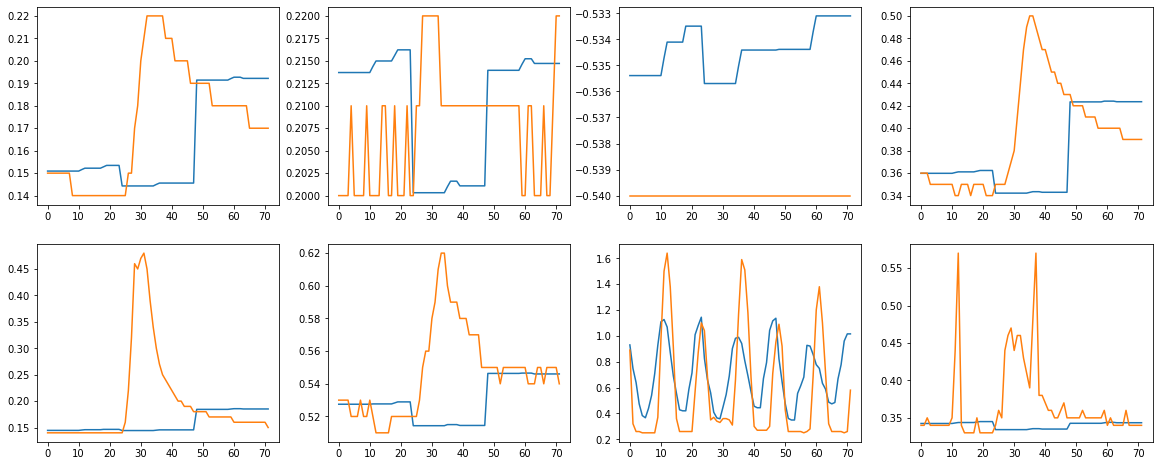

In [35]:
# 描画
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes[0, 0].plot(df_pred[df_pred['station_id'] == 0]['value'])
axes[0, 0].plot(df_true[df_true['station_id'] == 0]['value'])
axes[0, 1].plot(df_pred[df_pred['station_id'] == 1]['value'])
axes[0, 1].plot(df_true[df_true['station_id'] == 1]['value'])
axes[0, 2].plot(df_pred[df_pred['station_id'] == 2]['value'])
axes[0, 2].plot(df_true[df_true['station_id'] == 2]['value'])
axes[0, 3].plot(df_pred[df_pred['station_id'] == 3]['value'])
axes[0, 3].plot(df_true[df_true['station_id'] == 3]['value'])
axes[1, 0].plot(df_pred[df_pred['station_id'] == 4]['value'])
axes[1, 0].plot(df_true[df_true['station_id'] == 4]['value'])
axes[1, 1].plot(df_pred[df_pred['station_id'] == 5]['value'])
axes[1, 1].plot(df_true[df_true['station_id'] == 5]['value'])
axes[1, 2].plot(df_pred[df_pred['station_id'] == 6]['value'])
axes[1, 2].plot(df_true[df_true['station_id'] == 6]['value'])
axes[1, 3].plot(df_pred[df_pred['station_id'] == 7]['value'])
axes[1, 3].plot(df_true[df_true['station_id'] == 7]['value'])

モデルの保存

In [36]:
# 単数モデル
# joblib.dump(model, './submission/model/model.pkl', compress=3)

# 複数モデル
joblib.dump(periodic_model, './submission/model/periodic_model.pkl', compress=3)
joblib.dump(non_periodic_model, './submission/model/non_periodic_model.pkl', compress=3)

['./submission/model/non_periodic_model.pkl']